In [1]:
# Status - As of 6/10/2019 HHKNN > KNN > HHRF > RF > QDA
# Having trouble getting RF to perform well.

from covariates_gclass import *
import seaborn as sns
import networkx as nx
sns.set()
import _pickle as pickle
truth = pickle.load(open('LL1_truth.pkl', 'rb'))
train = pickle.load(open('LL1_train.pkl', 'rb'))
test = pickle.load(open('LL1_test.pkl', 'rb'))
truth['learningData'].head()

FileNotFoundError: [Errno 2] No such file or directory: 'LL1_truth.pkl'

In [ ]:
true_labels = truth['learningData']['classLabel'].values.astype(int)
G = train['0']
n = len(G)
truth

In [ ]:
true_labels

In [ ]:
def classify(X, Z, normal_params, fitted_model, m = None):
    """
    Classifies vertices.

    X - n x p; Normally distributed random variables.
    Z - n x d; Not normally distributed random variables.
    fitted_model - A sklearn model that can return posterior estimates.
    m - number of training data used to train fitted_model.
    """

    n, p = X.shape
    m, d = Z.shape
    
    K = len(normal_params)
    
    if n != m:
        raise ValueError('different number of samples for X, Z')
    
    if p == 1:
        norm_pdf = norm.pdf
        X = X.reshape((1, -1))[0]
    else:
        norm_pdf = mvn.pdf
        
    posteriors = fitted_model.predict_proba(Z)
    
    predictions=-1*np.zeros(n)

    for i in range(n):
        if m is None:
            smoothed_posterior = posteriors[i]
        else:
            posterior_plus = posteriors[i] + np.ones(K)/m
            smoothed_posterior = posterior_plus / np.sum(posterior_plus)
        temp_pdfs = np.array([norm_pdf(X[i], normal_params[j][0], normal_params[j][1]) for j in range(K)])
        posterior_pdf_prod = temp_pdfs * smoothed_posterior
        predictions[i] = int(np.argmax(posterior_pdf_prod))
        
    return predictions

In [ ]:
train['learningData']

In [ ]:
true_labels = truth['learningData']['classLabel'].values.astype(int)
G = train['0']
n = len(G)

A = nx.to_numpy_array(G)
train_labels = train['learningData']['classLabel'].values.astype(int)
train_idx = train['learningData']['d3mIndex'].values.astype(int)

unique_labels, n_seeds = np.unique(train_labels, return_counts=True)
K = len(unique_labels)
train_idx_split = [np.where(train_labels == i)[0] for i in unique_labels]
class_train_idx = [train_idx[tis] for tis in train_idx_split]

# train_idx = np.concatenate((class_train_idx)).astype(int)
test_idx = [k for k in range(n) if k not in train_idx]
labels = true_labels[test_idx]

MORE_ATTR = True
attr_number = 1
attrs = []
while MORE_ATTR:
    attr = 'attr'
    temp_attr = list(nx.get_node_attributes(G, 'attr' + str(attr_number)).values())
    if len(temp_attr) == 0:
        MORE_ATTR = False
    else:
        attrs.append(temp_attr)
        attr_number += 1
attrs = np.array(attrs).T
# for i in range(attrs.shape[1]):
#     attrs[:, i] = attrs[:, i]/max(attrs[:, i])

In [ ]:
train_labels[0]

In [ ]:
train_idx[0]

In [ ]:
#- Total number of seeds
m = np.sum(n_seeds)

#- estimate class probabilities
pi_hats = n_seeds / m

ase_obj = ASE(n_components=3, n_elbows=2)
X = ase_obj.fit_transform(A)

Z = attrs

XZ = np.concatenate((X, Z), axis=1)

#- Store mvn samples corresponding to seeds
seeds_norm = X[train_idx]

cov = np.cov(X[train_idx], rowvar=False)

#- Estimate normal parameters using seeds
mu1, cov1 = estimate_normal_parameters(X[class_train_idx[0]])
params1 = [mu1, cov]

mu2, cov2 = estimate_normal_parameters(X[class_train_idx[1]])
params2 = [mu2, cov]

mu3, cov3 = estimate_normal_parameters(X[class_train_idx[2]])
params3 = [mu3, cov]

#- Convenient way to store
params=[params1, params2, params3]

#- Store uniform samples corresponding to seeds
seeds_beta = Z[train_idx]

#- Using conditional indendence assumption (RF, KNN used for posterior estimates)
# if errors is None:
errors = [[] for _ in range(5)]

for _ in range(100):

    temp_pred = QDA(X[test_idx], pi_hats, params)
    qda_preds = temp_pred
    temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
    errors[0].append(temp_error)

    rf1 = RF(n_estimators=100, max_depth=int(np.round(np.log(seeds_beta.shape[0]))))
    rf1.fit(seeds_beta, true_labels[train_idx])

    knn1 = KNN(n_neighbors=int(np.round(np.log(seeds_beta.shape[0]))))
    knn1.fit(seeds_beta, true_labels[train_idx])

    smooth = True

    if smooth:
        temp_pred = classify(X[test_idx], Z[test_idx], params, rf1, m = m)
        temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
        errors[1].append(temp_error)

        temp_pred = classify(X[test_idx], Z[test_idx], params, knn1, m = m)
        temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
        errors[2].append(temp_error)
    else:
        temp_pred = classify(X[test_idx], Z[test_idx], params, rf1)
        temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
        errors[1].append(temp_error)

        temp_pred = classify(X[test_idx], Z[test_idx], params, knn1)
        temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
        errors[2].append(temp_error)

    #- Not using conditional independence assumption (RF, KNN used for classification)
    XZseeds = np.concatenate((seeds_norm, seeds_beta), axis=1)

    rf2 = RF(n_estimators=100, max_depth=int(np.round(np.log(m))))
    rf2.fit(XZseeds, true_labels[train_idx])
    temp_pred = rf2.predict(XZ[test_idx])
    temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
    errors[3].append(temp_error)

    knn2 = KNN(n_neighbors=int(np.round(np.log(m))))
    knn2.fit(XZseeds, true_labels[train_idx])

    temp_pred = knn2.predict(XZ[test_idx])
    temp_error = np.sum(temp_pred == true_labels[test_idx])/len(test_idx)
    errors[4].append(temp_error)

In [ ]:
np.concatenate(errors)
algorithms = ['qda', 'spa-rf', 'spa-knn', 'rf', 'knn']
algos = np.concatenate([100*[algo] for algo in algorithms])

# Usual boxplot
import pandas as pd
data = np.concatenate(errors)
df = pd.DataFrame(np.concatenate((np.array(data).reshape(-1, 1), np.array(algos).reshape(-1, 1)), axis=1))
df1 = pd.DataFrame(np.concatenate((np.array(data[100:]).reshape(-1, 1), np.array(algos[100:]).reshape(-1, 1)), axis=1))
df.columns = ['accuracy', 'algorithm']
df1.columns = ['accuracy', 'algorithm']
df['accuracy'] = pd.to_numeric(df['accuracy'])
df1['accuracy'] = pd.to_numeric(df1['accuracy'])

ax = sns.violinplot(x='algorithm', y='accuracy', data=df)
# ax.axhline(y = 0.9875, label = 'EXLine', c = 'r', alpha=0.5)
# ax.axhline(y=0.85125, label = 'current best ta1 pipeline', c = 'k', alpha=0.5)
plt.savefig('all_algos_LL1_overleaf.png')

ax = sns.violinplot(x='algorithm', y='accuracy', data=df1)
# ax.axhline(y = 0.9875, label = 'EXLine', c = 'r', alpha=0.5)
# ax.axhline(y=0.85125, label = 'current best ta1 pipeline', c = 'k', alpha=0.5)
plt.savefig('no_QDA_LL1_overleaf.png')

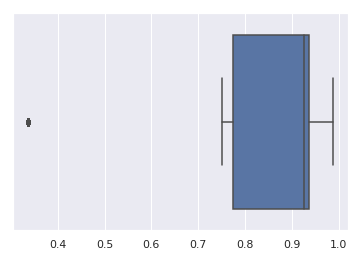

In [57]:
ax = sns.boxplot(x=df.columns, data=df)
 
# Add jitter with the swarmplot function.
# ax = sns.swarmplot(x='species', y='sepal_length', data=df, color="grey")

In [90]:
df1 = sns.load_dataset('iris')

numpy.ndarray

In [16]:
true_labels[test_idx]

array([2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 2, 1, 1, 2, 2,
       1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 2, 0, 2, 2, 1, 0,
       1, 2, 1, 0, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2])

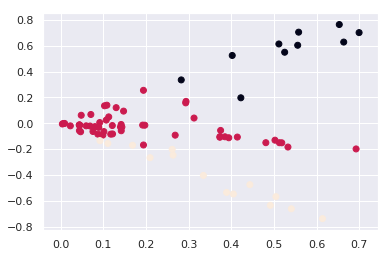

In [75]:
fig, ax = plt.subplots(1,1)
ax.scatter(X[test_idx, 0], X[test_idx, 1], c = qda_preds)

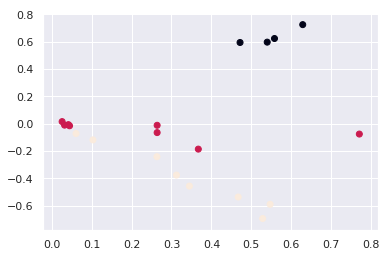

In [54]:
fig, ax = plt.subplots(1,1)
ax.scatter(X[train_idx, 0], X[train_idx, 1], c = true_labels[train_idx])

In [71]:
cov

array([[ 5.20875739e-02,  1.37910629e-02, -1.25109528e-02, ...,
         1.17546535e-03,  5.95967446e-05, -7.13742760e-26],
       [ 1.37910629e-02,  1.66694308e-01,  8.52944110e-03, ...,
        -1.66603381e-04,  4.27604905e-05,  1.68496662e-26],
       [-1.25109528e-02,  8.52944110e-03,  6.35593428e-02, ...,
        -8.67626170e-04, -1.60199882e-04,  1.06231935e-25],
       ...,
       [ 1.17546535e-03, -1.66603381e-04, -8.67626170e-04, ...,
         1.48475515e-04, -5.35820368e-06, -7.34991244e-27],
       [ 5.95967446e-05,  4.27604905e-05, -1.60199882e-04, ...,
        -5.35820368e-06,  1.02505349e-05, -4.15149747e-27],
       [-7.13742760e-26,  1.68496662e-26,  1.06231935e-25, ...,
        -7.34991244e-27, -4.15149747e-27,  2.52006496e-48]])